In [160]:
import numpy as np
import matplotlib.pyplot as plt

In [161]:
# SEED FOR HEAT SINK SHAPE
scaling = 100

nf = 5 # no of fins
fin_width = 0.4 # cm
gap_width = 0.8 # cm
fin_length = 5 # cm
base_length = 0.4 # cm

In [162]:

xf = ( nf * (fin_width) + (nf-1) * (gap_width) ) / scaling

print(xf)
dx = 0.07 /scaling
yf = (base_length + (fin_length)) / scaling
dy = dx
rt = 25

k = 237 # W / mK
h = 100 # W / m^2K
q = 120 / (yf ** 2)



0.039


In [163]:
xf

0.039

In [164]:
dx

0.0007000000000000001

In [165]:
states = np.ones((int(xf/dx+1),int(yf/dy+1)))

xArray = np.linspace(0,xf,states.shape[1])
yArray = np.linspace(0,yf,states.shape[0])

In [166]:
n = states.reshape(-1).shape[0]
A = np.zeros((n,n))
B = np.zeros(n)
print(A.shape)
print(B.shape)

(4368, 4368)
(4368,)


In [167]:
def mapA(j,i):
    if i < 0:
        i = states.shape[0] + i

    if j < 0:
        j = states.shape[1] + j

    return(j * states.shape[1] + i)

In [168]:
def findNearest(zArray,z):
    difference_array = np.absolute(zArray-z)
    index = difference_array.argmin()
    return index

In [169]:
for i in range(nf-1):
    x0 = (i)*(fin_width + gap_width) + fin_width
    x1 = x0 + gap_width 
    idx0 = findNearest(xArray, x0/scaling)
    idx1 = findNearest(xArray, x1/scaling)
    idy = findNearest(yArray, base_length/scaling)
    states[idy:,idx0:idx1] = -1

In [170]:
cMask = states.copy()


In [171]:
cMask[1:-1,0] = 2 # left convection
cMask[1:-1,-1] = 4 # right convection

midpoint = xf/2
xleft = midpoint - 2.5 / scaling 
xright = midpoint + 2.5 / scaling 
idxleft = findNearest(xArray, xleft)
idxright = findNearest(xArray, xright)

cMask[0,idxleft:idxright] = 0
for i in range(1,states.shape[1] - 1):
    if cMask[0,i] != 0:
        cMask[0,i] = 9 # bottom insulation
    if cMask[-1,i+1] != -1 and cMask[-1,i-1] != -1:
        cMask[-1,i] = 3
    if cMask[idy+1,i] == -1:
        cMask[idy,i] = 3

for j in range(1, states.shape[0] - 1):
    for i in range(1,states.shape[1] - 1):
        if cMask[j,i] != -1:
            if cMask[j,i+1] == -1:
                cMask[j,i] = 4
            elif cMask[j, i-1] == -1:
                cMask[j,i] = 2
                

for j in range(1, states.shape[0] - 1):
    for i in range(1,states.shape[1] - 1):
        if cMask[j,i] != -1:
            if cMask[j,i+1] == -1:
                cMask[j,i] = 4
            elif cMask[j, i-1] == -1:
                cMask[j,i] = 2

for i in range(1,states.shape[1] - 1):
    if cMask[-1,i] != -1 and cMask[-1,i+1] == -1:
        cMask[-1,i] = 6
    if cMask[-1,i] != -1 and cMask[-1,i-1] == -1:
        cMask[-1,i] = 5

cMask[0,0] = 7
cMask[0,-1] = 8
cMask[-1,0] = 5
cMask[-1,-1] = 6
    

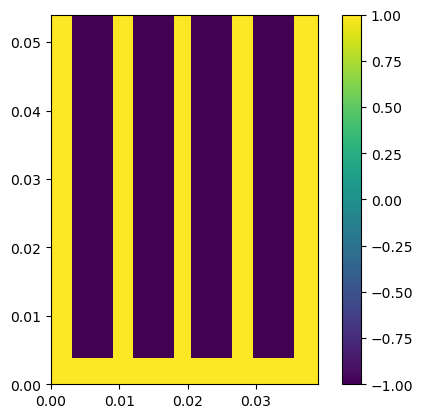

In [172]:
plt.imshow(states, extent=[0,xf,0,yf], origin="lower")
plt.colorbar()

In [173]:
cMask

array([[7., 0., 0., ..., 0., 0., 8.],
       [2., 1., 1., ..., 1., 1., 4.],
       [2., 1., 1., ..., 1., 1., 4.],
       ...,
       [2., 1., 1., ..., 1., 1., 4.],
       [2., 1., 1., ..., 1., 1., 4.],
       [5., 3., 3., ..., 3., 3., 6.]])

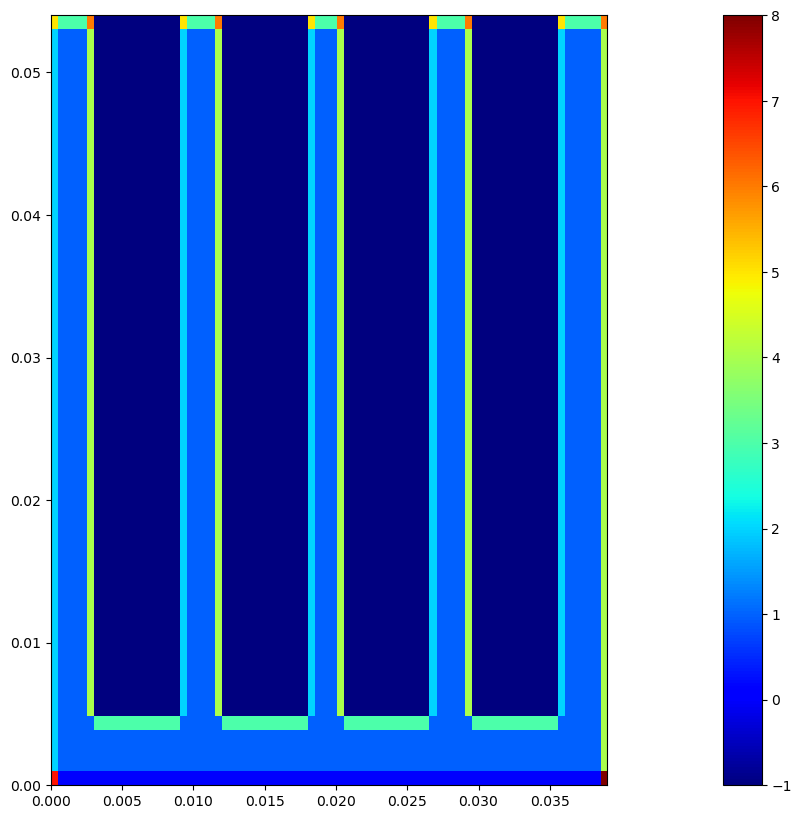

In [174]:
plt.figure(figsize = (30,10))
plt.imshow(cMask, extent=[0,xf,0,yf], origin="lower", cmap="jet")

plt.colorbar()

In [175]:
for j in range(states.shape[0]):
    for i in range(states.shape[1]):
        if cMask[j,i] >= 0:
            states[j,i] = 25

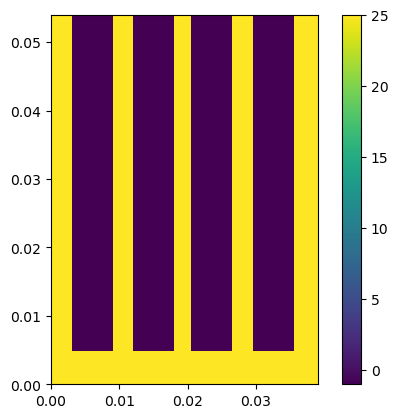

In [176]:
plt.imshow(states, extent=[0,xf,0,yf], origin="lower")
plt.colorbar()

In [177]:
counter = 0

In [178]:
for j in range(states.shape[0]):
  for i in range(states.shape[1]):

    if cMask[j,i] == 0: # heat flux
      # states[j,i] = (dx / (2*k)) * q + (2 * states[j+1,i] + states[j,i+1] + states[j,i-1])/(4)

      A[counter, mapA(j,i)] = -1
      A[counter, mapA(j+1,i)] = 1/2
      A[counter, mapA(j,i+1)] = 1/4
      A[counter, mapA(j,i-1)] = 1/4
      B[counter] = -dx / (2*k) * q

      counter += 1

    if cMask[j,i] == 9: # insulation
      # states[j,i] =  (2 * states[j+1,i] + states[j,i+1] + states[j,i-1])/(4)
      
      A[counter, mapA(j,i)] = -1
      A[counter, mapA(j+1,i)] = 1/2
      A[counter, mapA(j,i+1)] = 1/4
      A[counter, mapA(j,i-1)] = 1/4
      B[counter] = 0

      counter += 1
      
    if cMask[j,i] == 1: # central diff
      # states[j,i] = (states[j,i+1] + states[j,i-1] + states[j+1,i] + states[j-1,i]) / 4

      A[counter,mapA(j,i)] = -1
      A[counter,mapA(j-1,i)] = 1/4
      A[counter,mapA(j,i+1)] = 1/4
      A[counter,mapA(j,i-1)] = 1/4
      A[counter,mapA(j+1,i)] = 1/4
      B[counter] = 0

      counter += 1

    if cMask[j,i] == 4:  # convection right
      # states[j,i] = ((h * dx / k)* rt + (2 * states[j,i-1] + states[j+1,i] + states[j-1,i])/2)/(2 + h * dx / k)

      A[counter,mapA(j,i)] = -1
      A[counter,mapA(j,i-1)] = 1/(2 + h * dx / k)
      A[counter,mapA(j+1,i)] = 1/(2 + h * dx / k)/2
      A[counter,mapA(j-1,i)] = 1/(2 + h * dx / k)/2
      B[counter] = - ((h * dx / k)* rt)/(2 + h * dx / k)

      counter += 1

    if cMask[j,i] == 3: # convection top
      # states[j,i] = ((h * dx / k)* rt + (2 * states[j-1,i] + states[j,i+1] + states[j,i-1])/2)/(2 + h * dx / k)

      A[counter,mapA(j,i)] = -1
      A[counter,mapA(j-1,i)] = 1/(2 + h * dx / k)
      A[counter,mapA(j,i+1)] = 1/(2 + h * dx / k)/2
      A[counter,mapA(j,i-1)] = 1/(2 + h * dx / k)/2
      B[counter] = - ((h * dx / k)* rt)/(2 + h * dx / k)

      counter += 1

    if cMask[j,i] == 2: # convection left
      # states[j,i] = ((h * dx / k)* rt + (2 * states[j,i+1] + states[j+1,i] + states[j-1,i])/2)/(2 + h * dx / k)

      A[counter,mapA(j,i)] = -1
      A[counter,mapA(j,i+1)] = 1/(2 + h * dx / k)
      A[counter,mapA(j+1,i)] = 1/(2 + h * dx / k)/2
      A[counter,mapA(j-1,i)] = 1/(2 + h * dx / k)/2
      B[counter] = - ((h * dx / k)* rt)/(2 + h * dx / k)

      counter += 1


    if cMask[j,i] == 5: # TL corner
    # states[j,i] - states[j-1, i] = 0

      A[counter,mapA(j,i)] = 1
      A[counter,mapA(j,i+1)] = -1

      counter += 1

    if cMask[j,i] == 6: # TR corner
      # states[j,i] = states[j-1,i]

      A[counter,mapA(j,i)] = 1
      A[counter,mapA(j,i-1)] = -1

      counter += 1

    if cMask[j,i] == 7: # BL corner
      # states[j,i] = states[j+1,i]

      A[counter,mapA(j,i)] = 1
      A[counter,mapA(j,i+1)] = -1

      counter += 1

    if cMask[j,i] == 8: # BR corner
      # states[j,i] = states[j+1,i]

      A[counter,mapA(j,i)] = 1
      A[counter,mapA(j,i-1)] = -1

      counter += 1

    if cMask[j,i] == -1: # Not in Geometry
      A[counter,mapA(j,i)] = 1
      B[counter] = -1

      counter += 1


In [179]:
counter

4368

In [180]:
n

4368

In [181]:
assert(counter == n)

In [182]:
print(A)

[[ 1.         -1.          0.         ...  0.          0.
   0.        ]
 [ 0.25       -1.          0.25       ...  0.          0.
   0.        ]
 [ 0.          0.25       -1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -1.          0.24996309
   0.        ]
 [ 0.          0.          0.         ...  0.24996309 -1.
   0.24996309]
 [ 0.          0.          0.         ...  0.         -1.
   1.        ]]


In [183]:
X = np.linalg.inv(A) @ B.reshape((-1,1))
print(X)

KeyboardInterrupt: 

In [ ]:
states = X.reshape((states.shape[0], states.shape[1]))

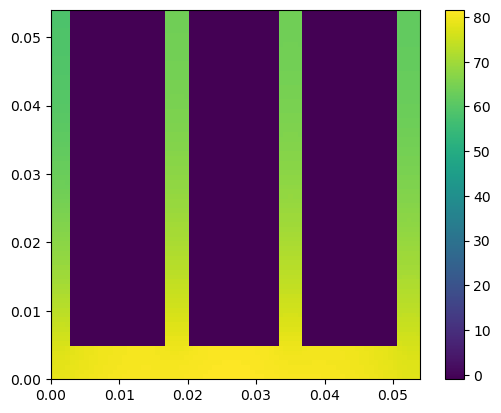

In [ ]:
plt.imshow(states, extent=[0,xf,0,yf], origin="lower")
plt.colorbar()

In [ ]:
np.max(states)

81.6248094610319